# 2023-08-24_Template

**Author**:  Y.M. Guo

**Create Date**： 2023-5-11



**Version**: V1.0

**Log**:



**Reference**:

**Supporting Material(attachments)**: 

### 0. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil as sh       #复制文件
from datetime import datetime
import os

def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    os.system("/usr/local/go/bin/mumax3-convert -numpy "+outputdir+"/*.ovf")
    #p = run(["/usr/local/go/bin/mumax3-convert","-numpy",+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    #if p.returncode != 0:
        #print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    os.system('/usr/local/go/bin/mumax3 -f -http ":6006" '+scriptfile)
    #p = run(['/usr/local/go/bin/mumax3','-f','-http ":6006"',scriptfile], stdout=PIPE, stderr=STDOUT)
    #if verbose or p.returncode != 0:
        #print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    print("程序正在运行中")
    
    return table, fields

def generate_script(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)

In [ ]:
Ipt=10 # ns

for Jn in range(20,6,-2):
    script=f"""
    //Specify output format
    OutputFormat = OVF2_TEXT

    setgridsize(30,30,2) //area of free layer=900nm2
    setcellsize(1e-9,1e-9,0.5e-9)
    setpbc(0,0,0)

    //setregion



    Msat = 1e6 //1000emu/cm^3=10e6A/m
    Aex = 15e-12
    Ku1 = 0.8e6 //efective perpendicular anisotropy constant 
    //K = 2e5 erg/cm  1st order uniaxial anisotropy constant (J/m3)
    AnisU = vector(0,0,1) // z-direction
    alpha = 0.005 //Gilbert damping alpha = 0.005
    m=uniform(0,0,-1)

    Bdc :=0.03   //External magnetic feld 300Oe on x direction
    //Static field
    B_ext = vector(Bdc, 0, 0) //Use to enhance the switch for x+  enhance to switch

    relax()

    //Add SOT
    // Define constants
    AlphaH := 0.3 //AlphaH equal to the theta jD
    SOTxi:=-2
    Pol = AlphaH
    Lambda=1
    Epsilonprime = alphaH/2 * SOTxi
    Fixedlayer = vector(0,-1,0) // p
    J=vector(0,0,0)
    autosave(m,1e-10)
    tableAutosave(1e-11)
    run(0.5e-9)
    J=vector(0,0,abs({Jn}*1e11))
    autosave(m,1e-10)
    tableAutosave(1e-11)
    run({Ipt}*1e-9)
    J=vector(0,0,0)
    autosave(m,1e-10)
    tableAutosave(1e-11)
    run(10e-9)
    """
    scriptname = "SOT-SJTU-"+str(Jn)+"A"
    table, fields = run_mumax3(script,scriptname)
    np.save(scriptname,fields)
    
    print(str(Jn)+"程序运行结束")
    plt.figure()
    plt.rcParams.update({'font.size': 18})
    nanosecond = 1e-9
    plt.plot( table["t"]/nanosecond, table["mx"],'r',alpha=0.3,label='mx')
    plt.plot( table["t"]/nanosecond, table["my"],'g',alpha=0.3,label='my')
    plt.plot( table["t"]/nanosecond, table["mz"],'b',alpha=0.3,label='mz')

    plt.ylim(-1.1,1.1)
    # 绘制垂直虚线，用于标记不同的时间点
    plt.axvline(x=0.5, color='red', linestyle='--', label='Pulse Start')
    plt.axvline(x=0.5+Ipt, color='black', linestyle='--', label='Pulse End')
    plt.text(0.5, 1, 'Pulse Start', color='red', verticalalignment='bottom', horizontalalignment='left')
    plt.text(0.5+Ipt, 1, 'Pulse End', color='black', verticalalignment='bottom', horizontalalignment='left')
    plt.legend()
    plt.xlabel("Time (ns)")
    plt.ylabel("Magnetization")
    plt.gcf().set_size_inches(12, 9)
    plt.savefig(scriptname+"t-m"+'.svg', format='svg')
    plt.show()
    
    t = table['t']
    mx = table['mx']
    my = table['my']
    mz = table['mz']

    # 创建3D图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制球面
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    x_sphere = np.sin(theta) * np.cos(phi)
    y_sphere = np.sin(theta) * np.sin(phi)
    z_sphere = np.cos(theta)


    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='b', alpha=0.1)
    ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='k', linewidth=0.1)
    # 绘制轨迹
    sc = ax.scatter(mx, my, mz, c=t, cmap='viridis', marker='o', alpha=0.8)
    cbar = fig.colorbar(sc, ax=ax, label='Time (t)')

    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, 1])
    plt.gcf().set_size_inches(12, 9)
    # 显示图形
    plt.savefig(scriptname+'sphere'+'.svg', format='svg')
    plt.show()
    
    
    print("Above is on "+str(Jn)+'e11A')
end

//mumax 3.10 [linux_amd64 go1.21.4(gc) CUDA-12.3]
//GPU info: NVIDIA GeForce RTX 3090(24268MB), CUDA Driver 11.7, cc=8.6, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: SOT-SJTU-20A.out/
//starting GUI at http://127.0.0.1:6006
OutputFormat = OVF2_TEXT
setgridsize(30, 30, 2)
setcellsize(1e-9, 1e-9, 0.5e-9)
setpbc(0, 0, 0)
//resizing...
// Initializing geometry 1 %
// Initializing geometry 100 %
Msat = 1e6
Aex = 15e-12
Ku1 = 0.8e6
AnisU = vector(0, 0, 1)
alpha = 0.005
m = uniform(0, 0, -1)
Bdc := 0.03
B_ext = vector(Bdc, 0, 0)
relax()


//Using cached kernel: /tmp/mumax3kernel_[30 30 2]_[0 0 0]_[1e-09 1e-09 5e-10]_6_


AlphaH := 0.3
SOTxi := -2
Pol = AlphaH
Lambda = 1
Epsilonprime = alphaH / 2 * SOTxi
Fixedlayer = vector(0, -1, 0)
J = vector(0, 0, 0)
autosave(m, 1e-10)
tableAutosave(1e-11)
run(0.5e-9)


In [ ]:
if __name__ == "__main__":
    # xxxxxx
    os.system("/usr/bin/shutdown")

In [ ]:
scriptname = "SOT-SJTU4-1d5e12A.out"
table, fields = run_mumax3(script,scriptname)
np.save(scriptname,fields)
print("程序运行结束")

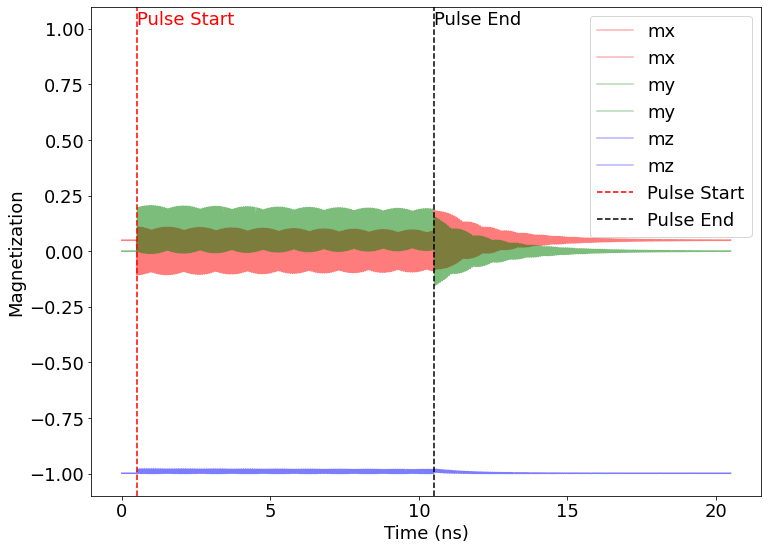

In [ ]:
from os import path
outputdir  = "SOT-SJTU-6A" + ".out"

table=read_mumax3_table(outputdir + "/table.txt")
plt.figure()
plt.rcParams.update({'font.size': 18})
nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"],'r',alpha=0.3,label='mx')
plt.plot( table["t"]/nanosecond, table["my"],'g',alpha=0.3,label='my')
plt.plot( table["t"]/nanosecond, table["mz"],'b',alpha=0.3,label='mz')

plt.ylim(-1.1,1.1)
# 绘制垂直虚线，用于标记不同的时间点
plt.axvline(x=0.5, color='red', linestyle='--', label='Pulse Start')
plt.axvline(x=10.5, color='black', linestyle='--', label='Pulse End')
plt.text(0.5, 1, 'Pulse Start', color='red', verticalalignment='bottom', horizontalalignment='left')
plt.text(0.5+10, 1, 'Pulse End', color='black', verticalalignment='bottom', horizontalalignment='left')
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")
plt.gcf().set_size_inches(12, 9)
plt.savefig('SOT-switch'+str(6)+'.svg', format='svg')
plt.show()
